In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torchvision.transforms import autoaugment
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils import compute_class_weight

import seaborn as sns

from tqdm import tqdm

In [62]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), 
    autoaugment.AutoAugment(autoaugment.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])

In [63]:
path_test = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
path_train = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'

ds_train = datasets.ImageFolder(path_train, transform=transform_train)
ds_test = datasets.ImageFolder(path_test, transform=transform_test)

In [64]:
print(f'Train dataset size is {len(ds_train)}')
print(f'Validation dataset size is {len(ds_val)}')
print(f'Test dataset size is {len(ds_test)}')

Train dataset size is 8144
Validation dataset size is 1629
Test dataset size is 8041


In [65]:
train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, shuffle=False)

In [66]:
df_names = pd.read_csv('/kaggle/input/stanford-car-dataset-by-classes-folder/names.csv', names=['name'])
num_classes = len(df_names['name'])
num_classes

196

In [67]:
y = torch.tensor(ds_train.targets)

classes, counts = torch.unique(y, return_counts=True)

class_weights = torch.tensor(compute_class_weight(
    class_weight='balanced', 
    classes=classes.numpy(),  
    y=y.numpy()
))

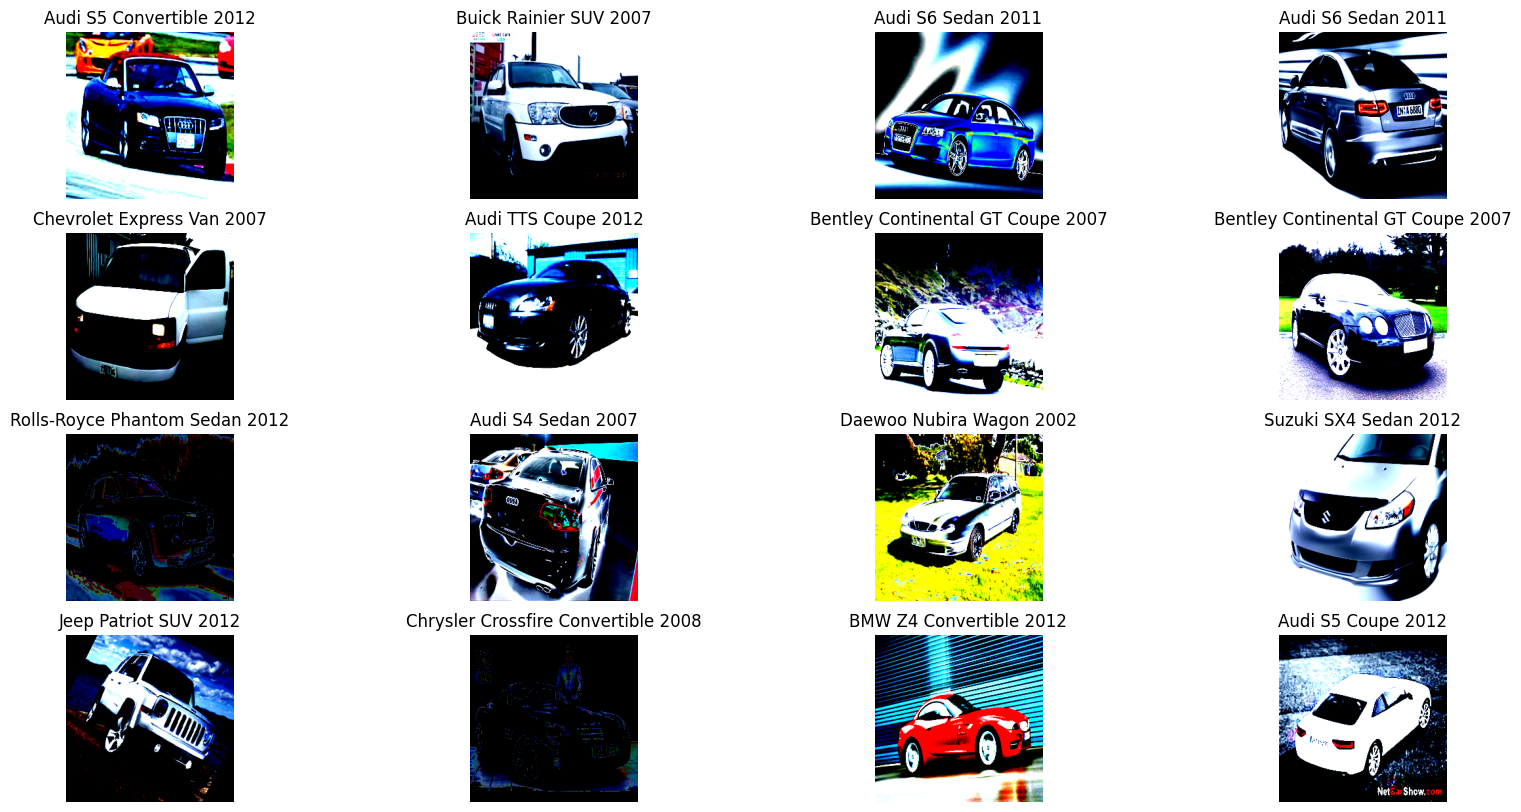

In [68]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off') # ici denormalise pour bien display

images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(20, 10))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[]) 
    imshow(images[idx])
    ax.set_title(ds_train.classes[labels[idx]])

plt.show()

In [69]:
# Load the pretrained model (ResNet18) from torchvision.models
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features

# Print the model architecture
print(model)

# Train the model using the training dataset

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Move the model to the device
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Create a SummaryWriter instance for logging
writer = SummaryWriter()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Wrap the train_dataloader with tqdm for the progress bar
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    train_loss = running_loss / len(ds_train)
    train_acc = running_corrects.double() / len(ds_train)

    print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc))
    

In [45]:
# Set the model to evaluation mode
model.eval()

running_loss = 0.0
running_corrects = 0

#Create the confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))

# Disable gradient calculation during testing
with torch.no_grad():
    for i, (data) in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update total samples and correct predictions
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (predicted == labels).sum().item()
        
        #Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# Calculate accuracy and lost
val_loss = running_loss / len(ds_test)
val_acc = running_corrects / len(ds_test)

print('val loss: {:.4f}, val acc: {:.4f}'.format(val_loss, val_acc))

NameError: name 'data_loader' is not defined

In [ ]:
#Print the matrix
import seaborn as sns

plt.figure(figsize=(15,10))

class_names = list(df_names['name'])

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
torch.save(model.state_dict(), 'resnet18_cars.pth')